In [39]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

def RotateRadian(angle_rad,center,size,img):
    #crop have shape(300,300)
    angle_degree = angle_rad*180/np.pi
    M = cv2.getRotationMatrix2D(center, angle_degree, 1.0)
    return cv2.warpAffine(img, M, (size, size))
def RotateDegree(angle_degree,center,size,img):
    #crop have shape(300,300)
    M = cv2.getRotationMatrix2D(center, angle_degree, 1.0)
    return cv2.warpAffine(img, M, (size, size))
def HSV_filter(img):
    imgHSV=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    h_min = 15
    h_max = 40
    s_min = 0
    s_max = 255
    v_min = 90
    v_max = 255
    lower= np.array([h_min,s_min,v_min])
    upper= np.array([h_max,s_max,v_max])
    mask = cv2.inRange(imgHSV,lower,upper)
    kernel = np.ones((5, 5), np.uint8)
    new_dilate = cv2.dilate(mask, kernel, iterations=1)
    mask_erosion = cv2.erode(new_dilate, kernel, iterations=2)
    new_mask = cv2.dilate(mask_erosion, kernel, iterations=1)
    imgResult = cv2.bitwise_and(imgHSV,imgHSV,mask = new_mask)
    return imgResult,new_mask
def show_images(img_list,name_list = None, max_column = 5,cmap = None):
    if len(img_list) == 0:
        return
    else:
        try:
            n = len(img_list)
            row = n // max_column+1
            fig,a =  plt.subplots(row,max_column)
            if row == 1:
                a = a.reshape(1,max_column)
            if max_column == 1:
                a = a.reshape(row,1)
            if name_list == None:
                for i in range(n):
                    row_plot = i // max_column
                    col_plot = i % max_column
                    if len(img_list[i].shape) ==2:
                        cmap = 'gray'
                    a[row_plot][col_plot].imshow(img_list[i],cmap)
                    
            else:
                for i in range(n):
                    row_plot = i // max_column
                    col_plot = i % max_column
                    a[row_plot][col_plot].imshow(img_list[i])
                    a[row_plot][col_plot].set_title(name_list[i])
            
            if isinstance(cmap,None):
                plt.imshow()
            else:
                plt.imshow(cmap=cmap)
        except Exception as e:
            print(e)

In [40]:
def GetCenter(imgGray):
    filter = np.zeros_like(imgGray)
    m,n = filter.shape
    c = int(m/2)
    filter = cv2.circle(filter, (c,c), int(0.9*c), (255),-1)
    ret,th =  cv2.threshold(imgGray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    bit_wise0 = np.where(filter==255,th,255 )
    
    circles = cv2.HoughCircles(bit_wise0,cv2.HOUGH_GRADIENT,1.2,100,
                            param1=300,param2=60,minRadius=int(0.5*c),maxRadius=int(0.9*c))
    circles = np.uint16(np.around(circles))[0,:]
    circle_info= np.uint16(np.mean(circles,axis=0))
    # centerPoint = circle_info[:2]
    # radius = circle_info[2]
    # filter1 = cv2.circle(filter, centerPoint, radius, (255),-1)
    # output = np.where(filter1==255,imgGray,0)
    # output = output[centerPoint[1]-radius:centerPoint[1]+radius,
    #                 centerPoint[0]-radius:centerPoint[0]+radius]
    # output = cv2.resize(output,(400,400))
    # print(centerPoint)
    # print(radius)
    # # centerPoint = circles[]
    # for i in circles:
    #     # draw the outer circle
    #     cv2.circle(imgGray,(i[0],i[1]),i[2],(0,255,0),2)
    #     # draw the center of the circle
    #     cv2.circle(imgGray,(i[0],i[1]),2,(0,0,255),3)
    return  circle_info
def findSubset(posA,posB):
    xA,yA = posA
    xB,yB = posB
    return np.array([min(xA,xB),max(yA,yB)])


FPS0: 499.9170441001192
FPS1: 251.9404132628544
FPS2: 201.01140611521134
(1390, 1, 2)
FPS3: 201.01140611521134
FPS4: 166.57945112990984
isinstance() arg 2 must be a type or tuple of types


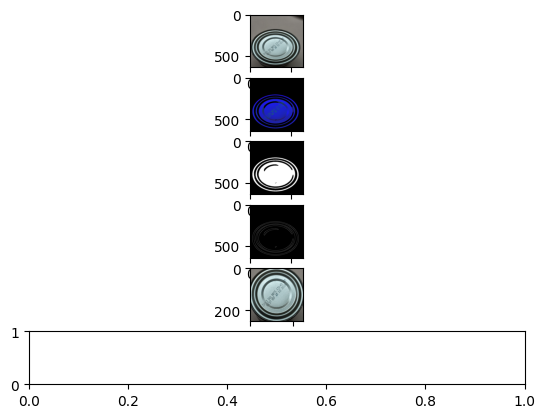

In [41]:

img = cv2.imread('img2.jpg')
start = time.time()
img = cv2.resize(img,(640,640))
print('FPS0:',1/(time.time()-start))
hsv_filt,new_mask = HSV_filter(img)
print('FPS1:',1/(time.time()-start))
blur = cv2.GaussianBlur(new_mask ,(5,5),0)
edged = cv2.Canny(blur, 0, 50)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
total_cnt = []
print('FPS2:',1/(time.time()-start))
for cnt in contours:
    if cv2.arcLength(cnt, True)>800:
        total_cnt.append(cnt)
        print(cnt.shape)
print('FPS3:',1/(time.time()-start))
total_cnt = np.concatenate(total_cnt,axis = 0)
box = cv2.boundingRect(total_cnt)
x,y,w,h = box
cropImg = img[y:y+h,x:x+w]
box = cv2.boundingRect(total_cnt)
cropImg = cv2.resize(cropImg,(250,250))
gray  = cv2.cvtColor(cropImg ,cv2.COLOR_BGR2GRAY)
print('FPS4:',1/(time.time()-start))
# plt.imshow(cropImg)
show_images([img,hsv_filt,new_mask,edged,cropImg],max_column=1)
# diagnoise


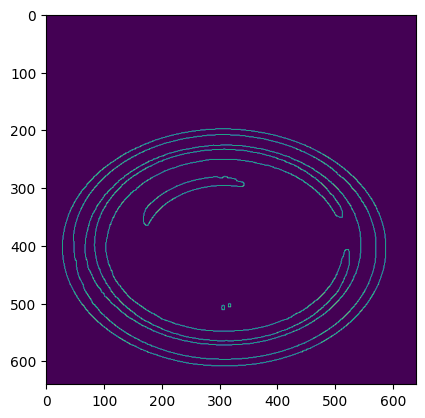

In [42]:
plt.imshow(edged)

FPS4: 333.3310021457522


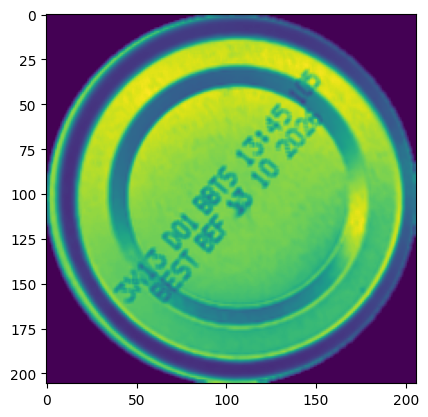

In [43]:
start = time.time()
cp = GetCenter(gray)
mask = np.zeros_like(gray)
cv2.circle(mask, cp[:2], max(cp[2],52), (1),-1)
Region = cv2.bitwise_and(gray,gray,mask=mask)
setPoint =cp[:2] - max(cp[2],52)
Region = Region[setPoint[1]:setPoint[1]+cp[2]*2,setPoint[0]:setPoint[0]+cp[2]*2]
# Region - 
Region_Blur = cv2.GaussianBlur(Region ,(3,3),2)
print('FPS4:',1/(time.time()-start))
plt.imshow(Region_Blur)

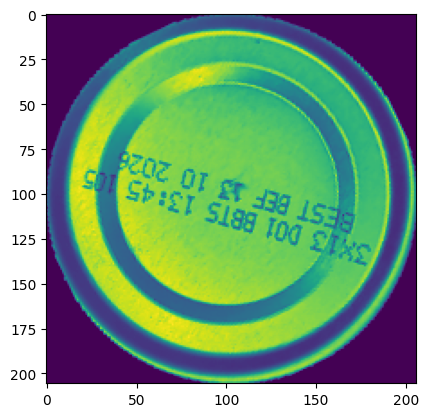

In [44]:
#Random rotate
angle_ran = np.random.randint(0,360)
Region = RotateRadian(angle_ran,center=(cp[2],cp[2]), size = cp[2]*2, img= Region)
Region_Blur = RotateRadian(angle_ran,center=(cp[2],cp[2]), size = cp[2]*2, img= Region_Blur)
plt.imshow(Region)

512
FPS:  142.81398753788008


C:\Users\THETRUNG\AppData\Local\Temp\ipykernel_22984\3725003182.py:23: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


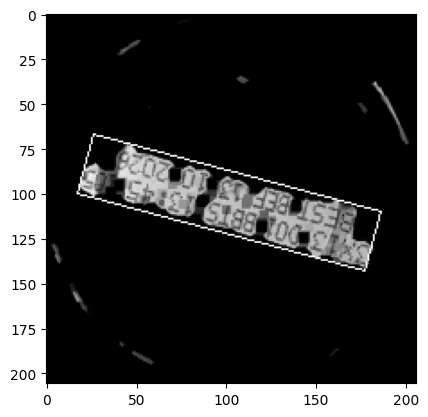

In [45]:
import time
start = time.time()
# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create()
fast.setNonmaxSuppression(0)
# find and draw the keypoints
kp = fast.detect(Region_Blur,None)
pts = cv2.KeyPoint_convert(kp)
filter = np.zeros_like(Region)
img2 = cv2.drawKeypoints(filter, kp, None, color=255,flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)[:,:,0]
kernel = np.ones((5, 5), np.uint8)
img2 = cv2.erode(img2, kernel, iterations=1)
# img2_dil = cv2.dilate(img2 , kernel, iterations=1)
ret,bin2 =  cv2.threshold(img2,150,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(bin2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
main_cnt = []
for cnt in contours:
    if cv2.contourArea(cnt) > 600:
        main_cnt.append(cnt)
main_cnt = np.vstack(main_cnt)
rect =cv2.minAreaRect(main_cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
draw = (Region*(img2/255)).astype(np.uint8)
cv2.drawContours(draw,[box],0,(255),1)
print(len(main_cnt))
print('FPS: ',1/(time.time()-start))
# plt.imshow(img2_dil,cmap='gray')
plt.imshow(draw,cmap='gray')

In [46]:
rect

((101.95347595214844, 105.69015502929688),
 (165.8021240234375, 33.75508117675781),
 14.962156295776367)

FPS:  995.3260560037969
[[ 17 100]
 [ 26  67]
 [186 110]
 [177 143]]


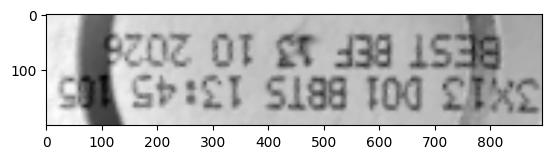

In [47]:
start = time.time()
angle_r = rect[2]
center = [int(rect[0][0]),int(rect[0][1])]
dim = [int(rect[1][0])+5,int(rect[1][1])+5]
rect_n = (rect[0],rect[1],0)
if rect[1][0]>rect[1][1]:
    rotated_ = RotateDegree(img=Region, angle_degree=angle_r, center=center, size=500)
    result = rotated_[int(center[1]-dim[1]/2):int(center[1]+dim[1]/2),
              int(center[0]-dim[0]/2):int(center[0]+dim[0]/2)]
else: 
    rotated_ = RotateDegree(img=Region, angle_degree=angle_r-90, center=center, size=500)
    result = rotated_[int(center[1]-dim[0]/2):int(center[1]+dim[0]/2),
                int(center[0]-dim[1]/2):int(center[0]+dim[1]/2)]
h,w = result.shape
height = 200
width = int(200*w/h)
result = cv2.resize(result,(width,height))
print('FPS: ',1/(time.time()-start))
print(box)
plt.imshow(result,cmap='gray')

In [48]:
# box = cv2.boxPoints(rect)
# p1 = box[1]
# p2 = box[2]
# p3 = box[0]
# p4 = box[3]
# h = int(np.sqrt(np.sum(np.power(p3-p1,2))))
# w = int(np.sqrt(np.sum(np.power(p2-p1,2))))

# height = 200
# width = int(200*w/h)

# pts1 = np.float32([p1,p2,p3,p4])
# pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])
# matrix = cv2.getPerspectiveTransform(pts1, pts2)
# result = cv2.warpPerspective(Region, matrix, (width , height))
# plt.imshow(result)

In [49]:
def ResortingBox(box):
    p1 = box[0]
    distance_square = np.sum(np.power(box-p1,2),axis=1)[1:]
    third_p = np.argmin(distance_square)+1
    last_p = np.argmax(distance_square)+1
    for p in [1,2,3]:
        if p not in [third_p,last_p]:
            second_p = p
    return [box[0], box[second_p], box[third_p], box[last_p]]


In [50]:
# p1,p2,p3,p4 = ResortingBox(box)
# h = int(np.sqrt(np.sum(np.power(p3-p1,2))))
# w = int(np.sqrt(np.sum(np.power(p2-p1,2))))

# height = 200
# width = int(200*w/h)

# pts1 = np.float32([p1,p2,p3,p4])
# pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])
# matrix = cv2.getPerspectiveTransform(np.array(pts1), pts2)
# result = cv2.warpPerspective(Region, matrix, (width , height))
# mask = cv2.warpPerspective(img2, matrix, (width , height))
# plt.imshow(result,cmap='gray')

FPS0:  124.97553708173177
FPS1:  1001.6979618054047
FPS2:  250.12248792414576
((459.47235107421875, 64.50434875488281), (713.21826171875, 66.66588592529297), 0.52724689245224)
((455.6369323730469, 141.01666259765625), (865.3111572265625, 66.01359558105469), 0.5417879223823547)
FPS3:  249.4353573423923
FPS: 946.3267429892894
isinstance() arg 2 must be a type or tuple of types


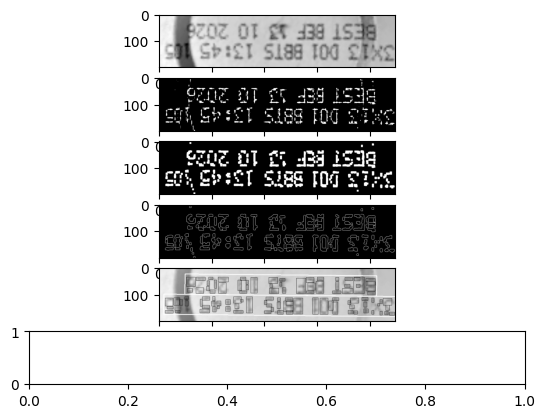

In [55]:
start = time.time()
gray_r = result.copy()
gamma = 0.7
gray_c = (np.power((gray_r)/255,gamma)*255).astype(np.uint8)
print('FPS0: ',1/(time.time()-start))
start = time.time()
ret,th = cv2.threshold(gray_c,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh2 = cv2.adaptiveThreshold(gray_c, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV,15, 5) 
print('FPS1: ',1/(time.time()-start+10**-6))
start = time.time()
kernel = np.ones((3, 3), np.uint8)
# binary = cv2.erode(thresh2, kernel, iterations=2)
# binary = cv2.medianBlur(binary,13)
binary = cv2.erode(thresh2, kernel, iterations=1)
binary = cv2.dilate(binary , kernel, iterations=3)

# binary = cv2.dilate(thresh2 , kernel, iterations=1)
# binary = cv2.erode(binary, kernel, iterations=2)
# plt.imshow(th)
# blur = cv2.GaussianBlur(binary ,(3,3),0)
edged = cv2.Canny(binary, 100, 200)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

draw = gray_c.copy()
up_cnt = []
down_cnt =[]
for cnt in contours:
    if cv2.arcLength(cnt,True)>40:
        x,y,w,h = cv2.boundingRect(cnt)
        if (h<90):
            if y <100:
                up_cnt.append(cnt)
            elif y>100:
                down_cnt.append(cnt)
        cv2.rectangle(draw,[x,y,w,h],color=(0))
print('FPS2: ',1/(time.time()-start))
start = time.time()
up_cnt = np.vstack(up_cnt)
down_cnt = np.vstack(down_cnt)
text_regions = []
text_region_color =[]
boxes_width = []
pad = 10
for cnt in [up_cnt,down_cnt]:
    # x,y,w,h = cv2.boundingRect(cnt)
    rect = cv2.minAreaRect(cnt)
    # print
    if rect[1][1]<rect[1][0]:
        rect = (rect[0],(rect[1][1]+pad,rect[1][0]+pad),90+rect[2]) # add padding (x,y),(w,h), angle
    else:
        rect = (rect[0],(rect[1][0]+pad,rect[1][1]+pad),rect[2]) # add padding (x,y),(w,h), angle
    
    boxes_width.append(rect[1][1])
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    height = 80
    width = int(height*rect[1][1]/rect[1][0])

    pts1 = np.float32([box[0],box[1],box[3],box[2]])
    pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])

    matrix = cv2.getPerspectiveTransform(np.array(pts1), pts2)
    text_region = cv2.warpPerspective(binary, matrix, (width , height))
    text_regions.append(text_region)
    text_region = cv2.warpPerspective(thresh2, matrix, (width , height))
    text_region_color.append(text_region)
    cv2.drawContours(draw,[box],0,(255),2)
    # cv2.rectangle(draw,[x,y,w,h],color=(0))
print('FPS3: ',1/(time.time()-start+10**-6))
start = time.time()
if boxes_width[0] < boxes_width[1]:
    up = cv2.flip(text_regions[1],1)
    up = cv2.flip(up,0)
    down = cv2.flip(text_regions[0],1)
    down = cv2.flip(down ,0)
    text_regions = [up,down]
if boxes_width[0] < boxes_width[1]:
    up = cv2.flip(text_region_color[1],1)
    up = cv2.flip(up,0)
    down = cv2.flip(text_region_color[0],1)
    down = cv2.flip(down ,0)
    text_region_color = [up,down]
print('FPS:',1/(time.time()-start+10**-6))
show_images([gray_c,thresh2,binary,edged,draw],max_column=1,cmap='gray')



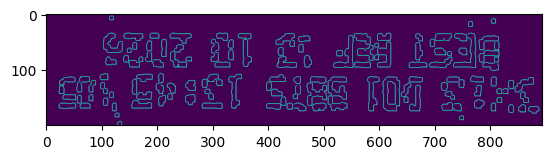

In [52]:
plt.imshow(edged)

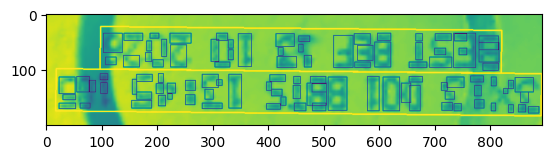

In [53]:
plt.imshow(draw)

isinstance() arg 2 must be a type or tuple of types


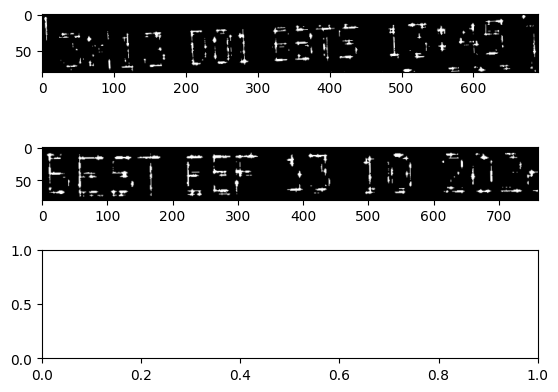

In [35]:
show_images(text_region_color,cmap='gray',max_column=1)

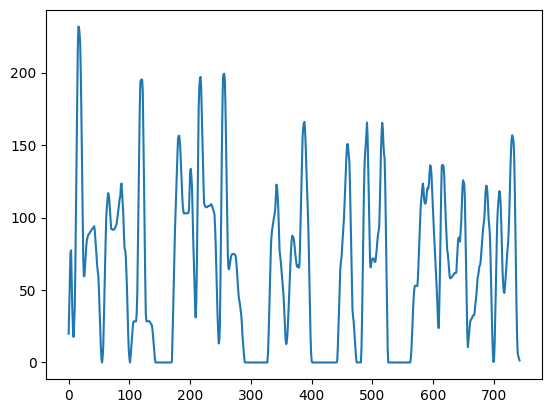

In [150]:
# plt.imshow(cv2.bitwise_not(text_regions[0]))
text_region =text_regions[1]
# kernel = np.ones((3, 3), np.uint8)
# text_region = cv2.dilate(text_region, kernel, iterations=1)

distribute = np.mean(text_region,axis=0)
filter = np.ones(5)/5
# plt.plot(np.diff(distribute))
# plt.plot(distribute)
distribute_conv = np.convolve(filter,distribute)
distribute_conv_g1 =np.where(distribute>=0,distribute,0) 
plt.plot(distribute_conv)

total time: 0.0009999275207519531


c:\ProgramData\anaconda3\envs\3dlabvision\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


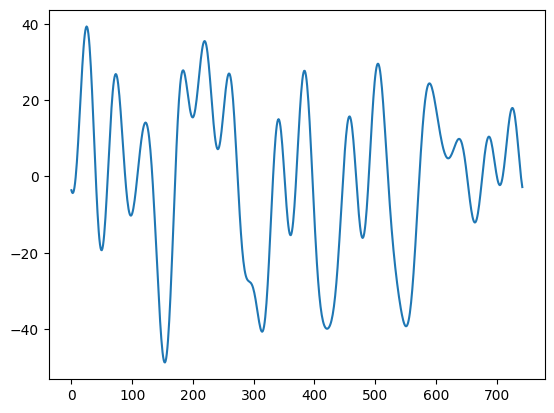

In [151]:
from scipy import signal
start = time.time()
f = distribute_conv
n = len(f)
fhat = np.fft.fft(f,n)                     # Compute the FFT
PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq)
## Use the PSD to filter out noise
indices = PSD>2        # Find all freqs with large power
# indices = (np.arange(n)<25)*(np.arange(n)>5)
indices = (np.arange(n)<20)*(np.arange(n)>0)
PSDclean = PSD * indices  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
ffilt = np.fft.ifft(fhat) # Inverse FFT for filtered time signal
print('total time:',time.time()-start)
plt.plot(ffilt)
# plt.plot(np.diff(ffilt))
# plt.plot(np.log10(np.diff(ffilt)))
# plt.plot(np.where(ffilt>-5,ffilt,-5))

[  0   2  50  98 154 200 241 314 361 421 479 551 620 664 705 743]
total time: 1702105270.5374491


C:\Users\THETRUNG\AppData\Local\Temp\ipykernel_27096\2585519427.py:51: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  a[row_plot][col_plot].imshow(img_list[i],cmap)


isinstance() arg 2 must be a type or tuple of types


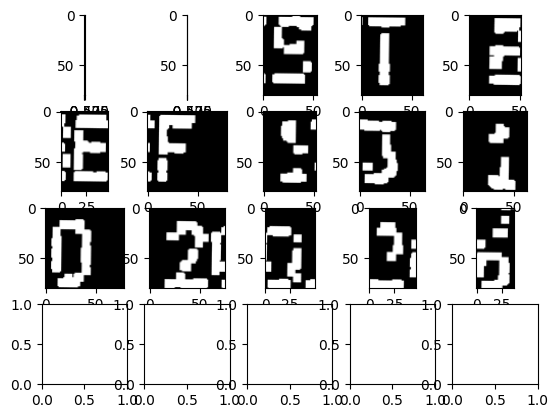

In [152]:
import numpy as np
from scipy.signal import argrelextrema
# for local minima

list_pos = argrelextrema(ffilt, np.less)[0]
list_pos = np.insert(list_pos,0,0)
list_pos = np.append(list_pos,len(ffilt))
print(list_pos)
text = []
for i in range(len(list_pos)-1):
    start = list_pos[i]-3
    stop = list_pos[i+1]+3
    text.append(text_region[:,start:stop])
print('total time:',time.time()-start)
show_images(text)


[ 25  73 122 184 219 259 341 384 458 504 589 638 687 726]
total time: 0.0019965171813964844
isinstance() arg 2 must be a type or tuple of types


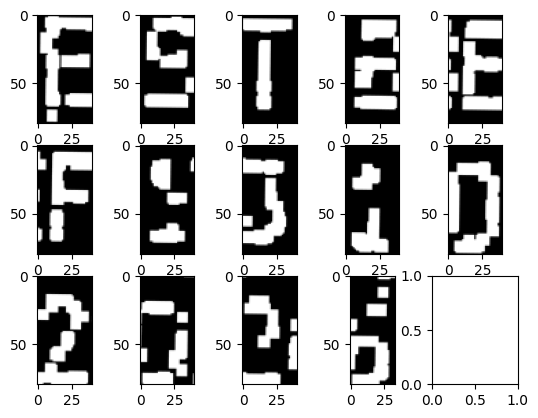

In [153]:
import numpy as np
from scipy.signal import argrelextrema
# for local maxima
start = time.time()
list_pos = argrelextrema(ffilt, np.greater)[0]
print(list_pos)
text = []
for i in range(len(list_pos)):
    cen = list_pos[i]
    text_extracted = text_region[:,cen-20:cen+20]
    if np.sum(text_extracted) >0:
        text.append(text_region[:,cen-20:cen+20])
print('total time:',time.time()-start)
show_images(text)

44
44
isinstance() arg 2 must be a type or tuple of types
isinstance() arg 2 must be a type or tuple of types


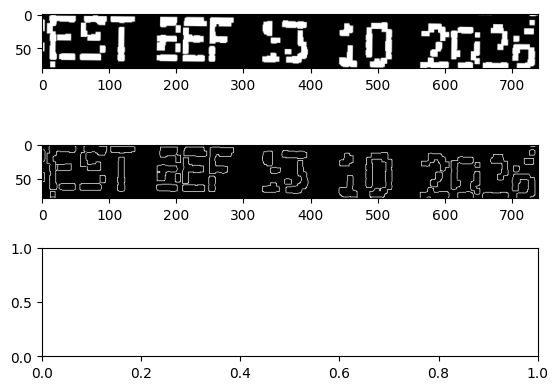

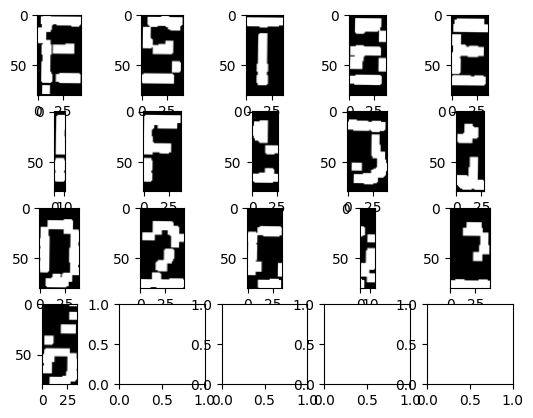

In [154]:
from operator import itemgetter
kernel = np.ones((3,3))
# thresh_eroded = cv2.erode(thresh2, kernel, iterations=1)
blur = cv2.GaussianBlur(text_region ,(3,3),0)
edged = cv2.Canny(blur, 100, 200)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# plt.imshow(text_region)
# plt.imshow(edged)
draw = np.zeros_like(edged)
mean_pos_x = np.array(sorted([np.mean(cnt,axis=0)[:,0] for cnt in contours]))

print(len(mean_pos_x))
print(len(np.diff(mean_pos_x)))
list_pos = np.array([[0,0]])
list_cnt = []
text =[]
count = 0
for cnt in contours:
    box = cv2.boundingRect(cnt)
    x,y,w,h= box
    if (w*h>250):
        count +=1
        cv2.rectangle(draw,box,color=(255))
        pos = np.array([x,x+w])
        center = x + w/2
        checker = list_pos - center 
        checker = (checker[:,0]*checker[:,1])<0  
          
        if checker.any()==True:
            idx = np.where(checker==True)[0][0]
            list_pos[idx] = findSubset(list_pos[idx],pos)
        else:
            list_pos = np.vstack([list_pos,pos])
list_pos = np.sort(list_pos,axis=0)
for pos in list_pos[1:]:
    start = pos[0]
    stop = pos[1]
    text.append(text_region[:,start:stop])
show_images([text_region,edged],max_column=1)
show_images(text)

FPS:  200.00495922941204
isinstance() arg 2 must be a type or tuple of types
isinstance() arg 2 must be a type or tuple of types


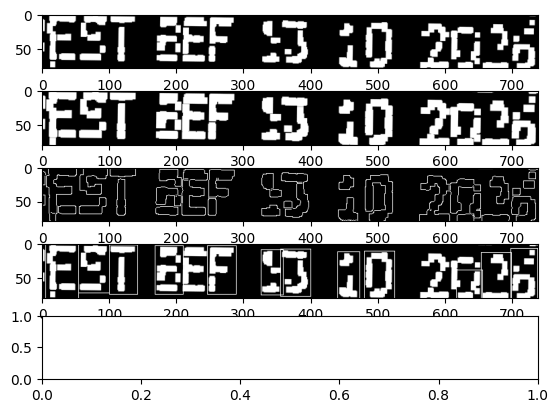

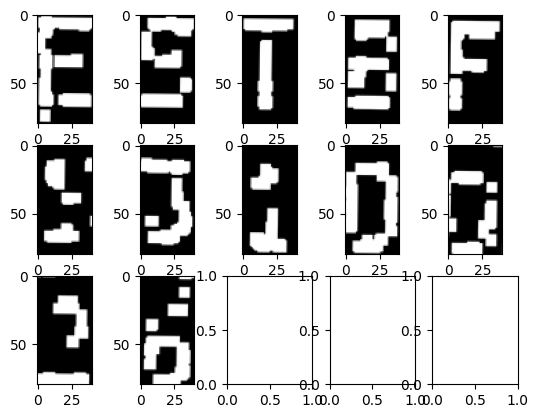

In [155]:
#Combine Maxima + contour
def GetTheBoundingBox(listBox):
    if len(list_box)>0:
        arr_box= np.array(listBox) 
        x_b = np.min(arr_box[:,0])-3
        y_b = np.min(arr_box[:,1])-3
        w_b = np.max(arr_box[:,0]+arr_box[:,2]) - x_b +3
        h_b = np.max(arr_box[:,1]+arr_box[:,3]) - y_b +3
        return(x_b,y_b,w_b,h_b)
    return False
start = time.time()
# for local maxima
start = time.time()
list_cen = argrelextrema(ffilt, np.greater)[0] # contain the center of weight point throughout x axis  
# for local maxima
list_pos = argrelextrema(ffilt, np.less)[0]
# blur = cv2.GaussianBlur(text_region ,(3,3),0)

kernel = np.ones((3,3))
thresh_eroded = cv2.dilate(text_region , kernel, iterations=1)
# for boundary in list_pos:
#     thresh_eroded[:,boundary-1:boundary+1]=0

edged = cv2.Canny(thresh_eroded, 100, 200)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

draw = text_region.copy()
list_boxes = [[] for i in range(len(list_cen))]
text =[]
for cnt in contours:
    box = cv2.boundingRect(cnt)
    x,y,w,h= box
    if w*h >100:
        x,y,w,h = [x+2,y+2,w-2,h-2] 

        checker1 = (list_cen - x+10)>0
        checker2 = (x + w - list_cen+10)>0

        index = np.where((checker1*checker2)==True)[0]
        if len(index) == 1:
            list_boxes[index[0]].append([x,y,w,h])
for list_box in list_boxes:
    box = GetTheBoundingBox(list_box)
    if box:
        x,y,w,h = box
        center = int(x+w/2)
        text_r = text_region[:,center-20:center+20]
        cv2.rectangle(draw,box,color=(255))
        text.append(text_r)
print('FPS: ',1/(time.time()-start))
show_images([text_region,thresh_eroded,edged,draw],max_column=1)
show_images(text)

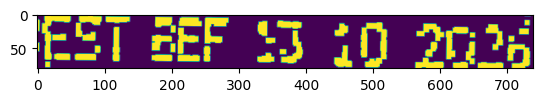

In [156]:
plt.imshow(text_regions[1])

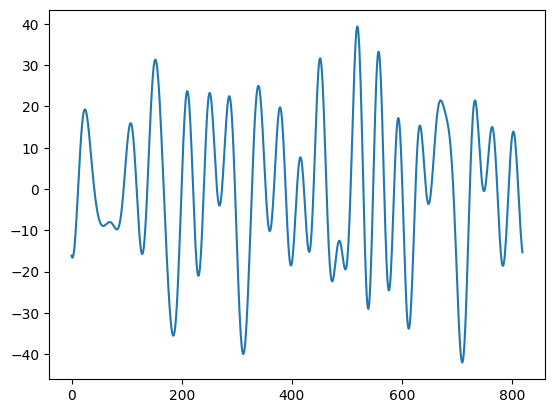

In [72]:
# plt.imshow(cv2.bitwise_not(text_regions[0]))
text_region = text_regions[0]
# kernel = np.ones((3, 3), np.uint8)
# text_region = cv2.dilate(text_region, kernel, iterations=1)

distribute = np.mean(text_region,axis=0)
filter = np.ones(3)/3
# plt.plot(np.diff(distribute))
# plt.plot(distribute)
distribute_conv = np.convolve(filter,distribute,mode='same')
distribute_conv_g1 =np.where(distribute>=0,distribute,0) 
f = distribute
n = len(f)
fhat = np.fft.fft(f,n)                     # Compute the FFT
## Use the PSD to filter out noise

indices = (np.arange(n)<25)*(np.arange(n)>5)

# indices = (np.arange(n)<20)*(np.arange(n)>8)
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
ffilt = np.fft.ifft(fhat) # Inverse FFT for filtered time signal
plt.plot(ffilt)
# plt.plot(ffilt)

FPS1:  100000000.0
FPS2:  100000000.0
FPS:  996.2618084919516
isinstance() arg 2 must be a type or tuple of types


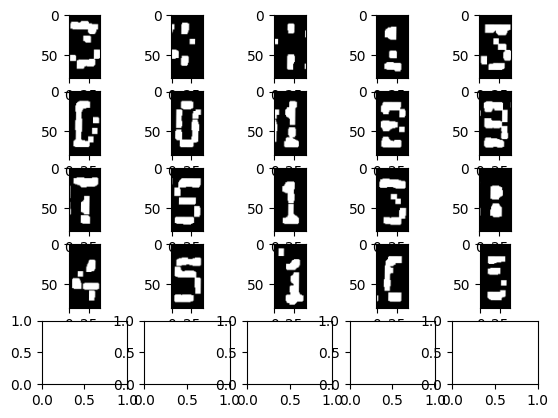

In [73]:
start = time.time()
# filter = np.ones(15)/15
# ffilt_conv = np.convolve(filter,ffilt,mode='same')[] # contain local mean value
# specify_ffilt = np.real(ffilt-ffilt_conv)
# rerange_ffilt =  specify_ffilt-np.min(specify_ffilt)
# rerange_ffilt = rerange_ffilt/np.max(rerange_ffilt)
# power_ffilt = rerange_ffilt
# Super_distribution = (power_ffilt+distribute)/2
power_ffilt = (ffilt-np.min(ffilt))
rerange_ffilt = power_ffilt/np.max(power_ffilt)
Super_distribution = rerange_ffilt*(distribute_conv+1)
print('FPS1: ',1/(time.time()-start+ 10**-8))
change = np.diff(Super_distribution>5)
list_pos = np.where(change > 0)[0]
list_pos = list_pos.reshape(-1,2)

print('FPS2: ',1/(time.time()-start+ 10**-8))

text = []
n = len(ffilt)
list_center = np.floor(np.mean(list_pos,axis=1)).astype(int)
for cen in list_center:
    text.append(text_region[:,max(cen-20,0):min(cen+20,n)])
print('FPS: ',1/(time.time()-start+ 10**-8))
show_images(text)

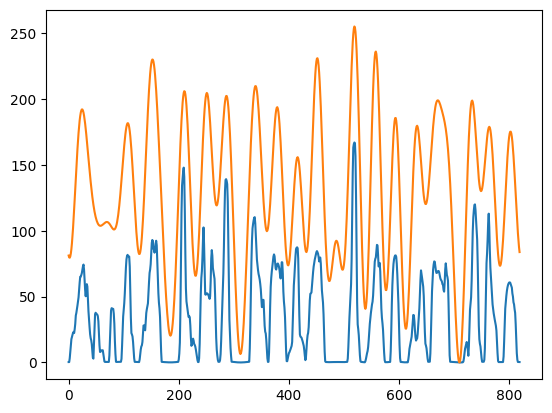

In [74]:
plt.plot(Super_distribution)
plt.plot(rerange_ffilt*255)
# plt.plot(distribute_conv)

c:\ProgramData\anaconda3\envs\3dlabvision\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


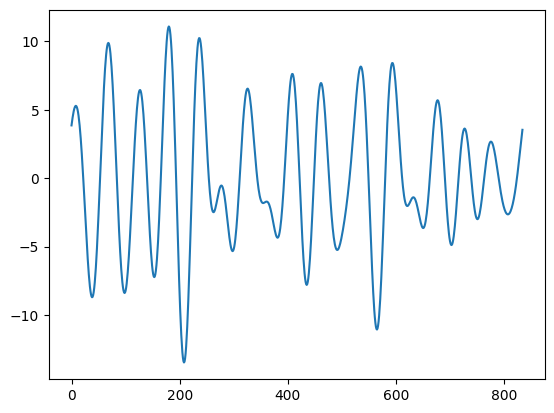

In [39]:
# plt.imshow(cv2.bitwise_not(text_regions[0]))
text_region = text_regions[1]

distribute = np.mean(text_region,axis=0)
filter = np.ones(5)/5
distribute_conv = np.convolve(filter,distribute,mode='same')
# distribute_conv = np.convolve(distribute_conv,distribute,mode='same')
distribute_conv_g1 =np.where(distribute>=0,distribute,0) 
f = distribute
n = len(f)
fhat = np.fft.fft(f,n)                     # Compute the FFT
## Use the PSD to filter out noise
# indices = (np.arange(n)<25)*(np.arange(n)>5)
indices = (np.arange(n)<20)*(np.arange(n)>8)
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
ffilt = np.fft.ifft(fhat) # Inverse FFT for filtered time signal
plt.plot(ffilt)

In [3]:

#Combine Maxima + contour + distribution 
def GetTheBoundingBox(listBox):
    if len(listBox)>0:
        arr_box= np.array(listBox) 
        x_b = np.min(arr_box[:,0])-3
        y_b = np.min(arr_box[:,1])-3
        w_b = np.max(arr_box[:,0]+arr_box[:,2]) - x_b +3
        h_b = np.max(arr_box[:,1]+arr_box[:,3]) - y_b +3
        return(x_b,y_b,w_b,h_b)
    return False
start = time.time()
# for local maxima
start = time.time()
list_cen = argrelextrema(ffilt, np.greater)[0] # contain the center of weight point throughout x axis  

#distribution to get the boundingBox
power_ffilt = (ffilt-np.min(ffilt))
rerange_ffilt = power_ffilt/np.max(power_ffilt)
Super_distribution = rerange_ffilt*(distribute_conv+1)
Super_distribution= np.convolve(filter, Super_distribution,mode='same')
# Super_distribution = np.clip(Super_distribution,0,255)
change = np.diff(Super_distribution>1)
change[-1] = 0
list_pos = np.where(change > 0)[0]
# list_pos = list_pos.reshape(-1,2)

# Contours to get the region of text
text = []
n = len(ffilt)

kernel = np.ones((4,4))
thresh_eroded = cv2.dilate(text_region , kernel, iterations=1)
for boundary in list_pos:
    thresh_eroded[:,boundary-1:boundary+1]=0

edged = cv2.Canny(thresh_eroded, 100, 200)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

draw = text_region.copy()
list_boxes = [[] for i in range(len(list_cen))]
text =[]
for cnt in contours:
    box = cv2.boundingRect(cnt)
    x,y,w,h= box
    if w*h >50:
        x,y,w,h = [x+2,y+2,w-2,h-2] 

        checker1 = (list_cen - x+10)>0
        checker2 = (x + w - list_cen+10)>0

        index = np.where((checker1*checker2)==True)[0]
        if len(index) == 1:
            list_boxes[index[0]].append([x,y,w,h])
for list_box in list_boxes:
    box = GetTheBoundingBox(list_box)
    if box:
        x,y,w,h = box
        center = int(x+w/2)
        text_r = text_region[:,max(center-20,0):min(center+20,n)]
        cv2.rectangle(draw,box,color=(255))
        text.append(text_r)
print('FPS: ',1/(time.time()-start))
print(n)
show_images([text_region,thresh_eroded,edged,draw],max_column=1)
show_images(text)

NameError: name 'ffilt' is not defined

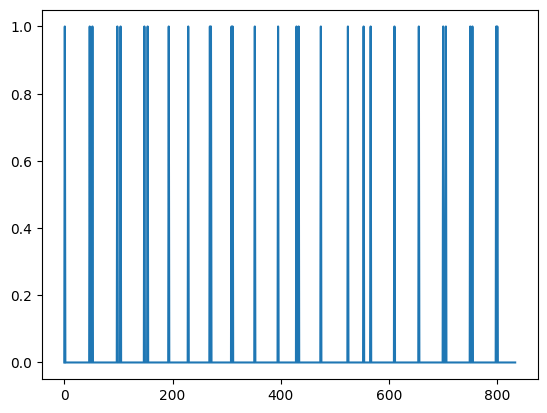

In [38]:
plt.plot(change)

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

def RotateRadian(angle_rad,center,size,img):
    #crop have shape(300,300)
    angle_degree = angle_rad*180/np.pi
    M = cv2.getRotationMatrix2D(center, angle_degree, 1.0)
    return cv2.warpAffine(img, M, (size, size))
def RotateDegree(angle_degree,center,size,img):
    #crop have shape(300,300)
    M = cv2.getRotationMatrix2D(center, angle_degree, 1.0)
    return cv2.warpAffine(img, M, (size, size))
def HSV_filter(img):
    imgHSV=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    h_min = 15
    h_max = 40
    s_min = 0
    s_max = 255
    v_min = 90
    v_max = 255
    lower= np.array([h_min,s_min,v_min])
    upper= np.array([h_max,s_max,v_max])
    mask = cv2.inRange(imgHSV,lower,upper)
    kernel = np.ones((5, 5), np.uint8)
    new_dilate = cv2.dilate(mask, kernel, iterations=1)
    mask_erosion = cv2.erode(new_dilate, kernel, iterations=2)
    new_mask = cv2.dilate(mask_erosion, kernel, iterations=1)
    imgResult = cv2.bitwise_and(imgHSV,imgHSV,mask = new_mask)
    return imgResult,new_mask
def show_images(img_list,name_list = None, max_column = 5,cmap = None):
    if len(img_list) == 0:
        return
    else:
        try:
            n = len(img_list)
            row = n // max_column+1
            fig,a =  plt.subplots(row,max_column)
            if row == 1:
                a = a.reshape(1,max_column)
            if max_column == 1:
                a = a.reshape(row,1)
            if name_list == None:
                for i in range(n):
                    row_plot = i // max_column
                    col_plot = i % max_column
                    if len(img_list[i].shape) ==2:
                        cmap = 'gray'
                    a[row_plot][col_plot].imshow(img_list[i],cmap)
                    
            else:
                for i in range(n):
                    row_plot = i // max_column
                    col_plot = i % max_column
                    a[row_plot][col_plot].imshow(img_list[i])
                    a[row_plot][col_plot].set_title(name_list[i])
            
            if isinstance(cmap,None):
                plt.imshow()
            else:
                plt.imshow(cmap=cmap)
        except Exception as e:
            print(e)

FPS:  9.43409433410558
isinstance() arg 2 must be a type or tuple of types
isinstance() arg 2 must be a type or tuple of types
isinstance() arg 2 must be a type or tuple of types


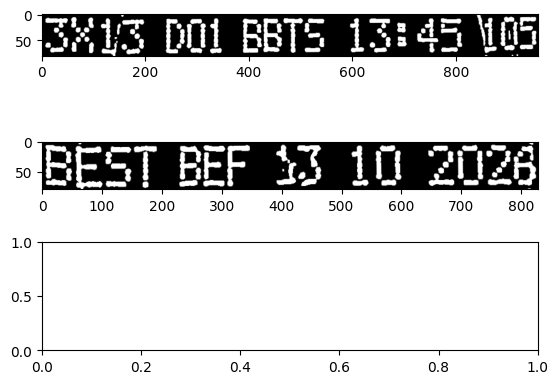

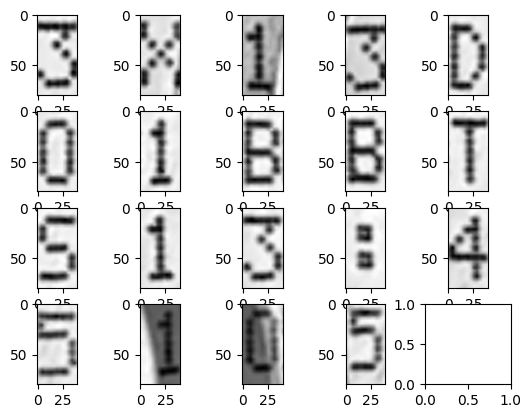

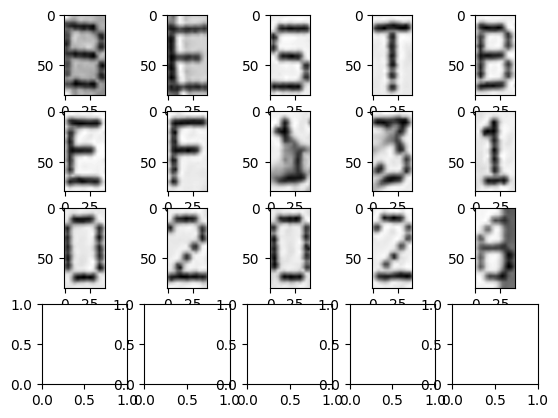

In [2]:
from computorVision_approach.Text_detection import *
import time
start = time.time()
tool = FirstProgress()
img = cv2.imread('img2.jpg')
Region, Region_Blur = tool.get_Can_Region(img)
text_regions = tool.GetTextRegion(Region, Region_Blur)
text = tool.TextExtracting(text_regions)
print('FPS: ',1/(time.time()-start))
show_images(text_regions,max_column=1)
show_images(text[0])
show_images(text[1])

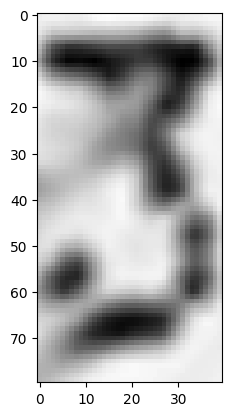

In [11]:
plt.imshow(text[1][],cmap='gray')